In [1]:
import numpy as np
import glob
import csv
import os

import matplotlib.pyplot as plt

from scipy.signal import spectrogram
from scipy.io import wavfile


plt.style.use('ggplot')

In [2]:
# Functions for generating spectrograms from WAVE files
def plot_spectrogram(file):
        rate, data = wavfile.read(file)
#         rms = np.sqrt(np.mean(data ** 2))
#         data = data / rms
        f, t, Sxx = spectrogram(data, 
                                rate,
                                scaling='density',
                                nperseg=256)
        
        plt.pcolormesh(t, f, Sxx)
        plt.ylabel('Frequency [Hz]')
        plt.xlabel('Time [Sec]')
        
        plt.show()
        
        return rate, data, f, t, Sxx


def gen_spectrograms(in_ddir, out_ddir):
    
    if not os.path.exists(out_ddir):
        os.mkdir(out_ddir)
        
    if not os.path.exists(out_ddir + '/spec'):
        os.makedirs(out_ddir + '/spec')
        
    if not os.path.exists(out_ddir + '/subspec'):
        os.makedirs(out_ddir + '/subspec')
        
    filenames = glob.glob(os.path.join(in_ddir, '*wav'))
    for fn in filenames:
        rate, data = wavfile.read(fn)
        
        # Generate spectrogram
        Pxx, freqs, bins, im = plt.specgram(data, NFFT=300, Fs=rate, 
                                            mode='psd', noverlap=200, scale='dB',
                                            xextent=(0,np.floor(data.shape[0]/rate)))
        
        # Rescale to decibel
#         Pxx_dcb = 10 * np.log10(Pxx)
        Pxx_dcb = Pxx
        
        # Generate supspectra
        subspecs = gen_subspecs(5.0, Pxx_dcb, bins, 100)

        # Save spectrogram and subspectra arrays
        fn_prefix = fn.split('.')[0].split('/')[-1]
        np.save(os.path.join(out_ddir + '/spec', fn_prefix), Pxx_dcb)
        for i, s in enumerate(subspecs):
            np.save(os.path.join(out_ddir + '/subspec', fn_prefix + '_' + str(i)), s)
        
#         # Generate and save spectrogram plot
#         f = plt.gcf()
#         f.set_figwidth(12)
#         f.set_figheight(3.5)
        
#         plt.savefig(os.path.join(out_ddir + '/spect', fn_prefix + '.png'), 
#                     format='png')
        

def gen_training_spectrograms(training_ddir, out_ddir):
    train_sub_ddir = glob.glob(os.path.join(training_ddir, '*'))
    for tsd in train_sub_ddir:
        gen_spectrograms(tsd, out_ddir)
        

def gen_subspecs(subspec_size, Pxx, bins, max_len):
    
    num_windows = (bins[-1] // subspec_size).astype(np.int32)

    window_indices = np.zeros(num_windows)
    for n in range(num_windows):
        window_indices[n] = np.where(bins < subspec_size * (n + 1))[0][-1]

    # Partition spectrogram into subspectra
    subspecs = np.split(Pxx, window_indices + 1, axis=1)
    
    # Remove last subpectrum if too small
    if subspecs[-2].shape[1] - subspecs[-1].shape[1] > 1:
        subspecs = subspecs[:-1]

    # Pad subspectra to ensure uniform length
    #max_len = np.max([s.shape[1] for s in subspecs])

    for i, s in enumerate(subspecs):
        while s.shape[1] < max_len:
            s = np.insert(s, obj=s.shape[1], values=0, axis=1)
        subspecs[i] = s
            
    return subspecs
        

# Functions for consolidating REFERENCE files
def gen_training_reference(training_ddir, out_ddir):
    out_reference_file = os.path.join(out_ddir, 'REFERENCE.csv')
    
    with open(out_reference_file, 'w') as write_file:
        writer = csv.writer(write_file, delimiter=',')
        
        train_sub_ddir = glob.glob(os.path.join(training_ddir, '*'))
        
        for tsd in train_sub_ddir:
            in_reference_file = os.path.join(tsd, 'REFERENCE.csv') 
            
            with open(in_reference_file, 'r') as read_file:
                reader = csv.reader(read_file, delimiter=',')

                for row in reader:
                    writer.writerow(row)
                                    

In [3]:
# Functions for accessing length of sequences in WAVE files
def get_recording_lengths(ddir):
    filenames = glob.glob(os.path.join(ddir, '*wav'))
    seq_lengths = np.zeros(len(filenames))
    
    for i, fn in enumerate(filenames):
        _, data = wavfile.read(fn)
        seq_lengths[i] = data.shape[0]
        
    return seq_lengths


def get_training_recording_lengths(training_ddir):
    train_sub_ddir = glob.glob(os.path.join(training_ddir, '*'))

    for i, tsd in enumerate(train_sub_ddir):
        if i == 0:
            seq_lengths = get_recording_lengths(tsd)
        else:
            seq_lengths = np.concatenate([seq_lengths, get_recording_lengths(tsd)])
        
    return seq_lengths
    

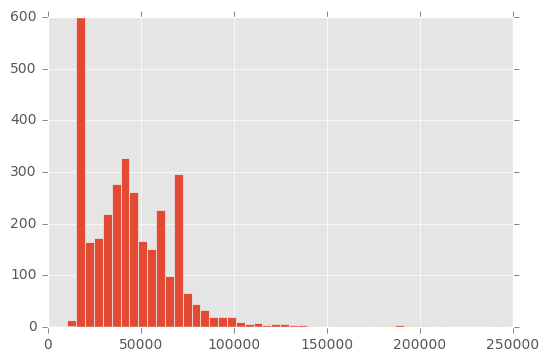

In [4]:
seq_lengths = get_training_recording_lengths('data/raw/training')

plt.hist(seq_lengths, bins='auto')
plt.show()

In [5]:
# Consolidate reference files
gen_training_reference('data/raw/training/', 'data/spect/training/')

In [5]:
# Generate spectrograms and subspectrograms for all training data
gen_training_spectrograms(training_ddir='data/raw/training/', 
                          out_ddir='data/spectrogram/training/')

# Generate spectrograms and subspectrograms for validation data
gen_spectrograms('data/raw/validation/', 'data/spectrogram/validation/')

/Users/torod/anaconda2/envs/py35/lib/python3.5/site-packages/numpy/lib/shape_base.py:422: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  sub_arys.append(_nx.swapaxes(sary[st:end], axis, 0))
/Users/torod/anaconda2/envs/py35/lib/python3.5/site-packages/matplotlib/axes/_axes.py:7017: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


In [234]:
x=np.load('data/spect/training/subspec/a0001_0.npy')
x.shape

(151, 100)

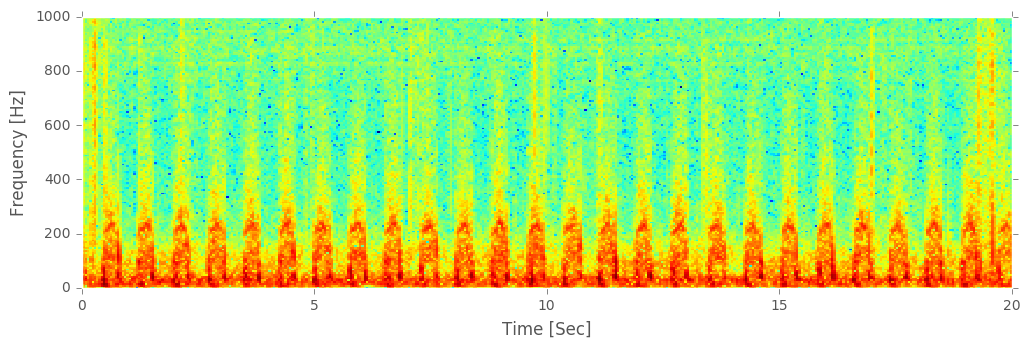

In [128]:
rate, data = wavfile.read("data/raw/training/training-a/a0002.wav")

Pxx, freqs, bins, im = plt.specgram(data, NFFT=300, Fs=rate, 
                                    mode='psd', noverlap=200, scale='dB',
                                    xextent=(0,np.floor(data.shape[0]/rate)))

plt.pcolormesh(bins, freqs, 10*np.log10(Pxx))
plt.xlim((0, np.floor(data.shape[0]/rate)))
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [Sec]')

f = plt.gcf()
f.set_figwidth(12)
f.set_figheight(3.5)

plt.show()

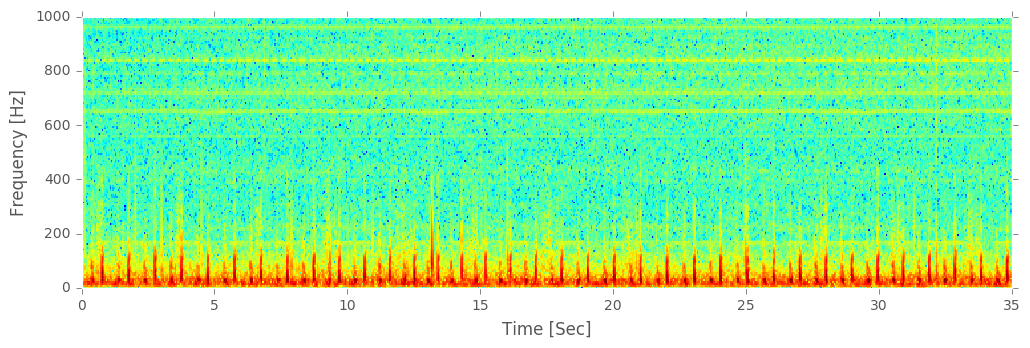

In [167]:
rate, data = wavfile.read("data/raw/training/training-a/a0001.wav")

Pxx, freqs, bins, im = plt.specgram(data, NFFT=300, Fs=rate, 
                                    mode='psd', noverlap=200, scale='dB',
                                    xextent=(0,np.floor(data.shape[0]/rate)))

plt.pcolormesh(bins, freqs, 10*np.log10(Pxx))
plt.xlim((0, np.floor(data.shape[0]/rate)))
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [Sec]')

f = plt.gcf()
f.set_figwidth(12)
f.set_figheight(3.5)

plt.show()